In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [10]:
diesel_imp = pd.read_csv('./data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
diesel_imp.set_index('Fecha', inplace=True)

# Limpiar espacios en los nombres de columnas
diesel_imp.columns = diesel_imp.columns.str.strip()

# Sumar las tres columnas de Diesel
diesel_imp['Diesel'] = (
    diesel_imp['Diesel bajo azufre'] +
    diesel_imp['Diesel ultra bajo azufre'] +
    diesel_imp['Diesel alto azufre']
)

# Extraer la serie de tiempo
diesel_imp_h = diesel_imp['Diesel']
diesel_imp_h.head()

Fecha
2001-01-01    566101.99
2001-01-02    489525.80
2001-01-03    575559.68
2001-01-04    437745.42
2001-01-05    552609.13
Name: Diesel, dtype: float64

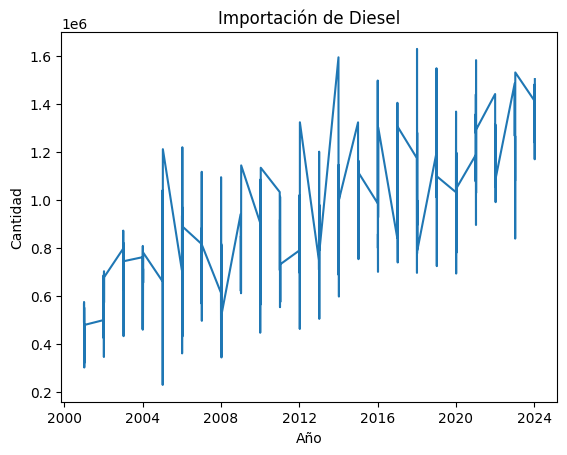

In [11]:
plt.plot(diesel_imp_h)
plt.gca().set(title="Importación de Diesel", ylabel="Cantidad", xlabel="Año")
plt.show()

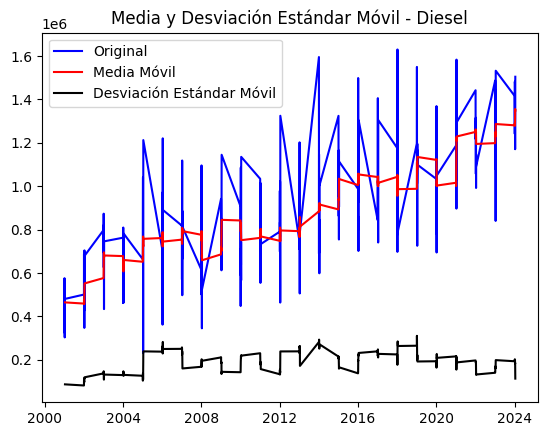

In [12]:
mediaMovil = diesel_imp_h.rolling(window=12).mean()
deMovil = diesel_imp_h.rolling(window=12).std()

original = plt.plot(diesel_imp_h, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label='Media Móvil')
ds = plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
plt.legend(loc='best')
plt.title('Media y Desviación Estándar Móvil - Diesel')
plt.show(block=False)

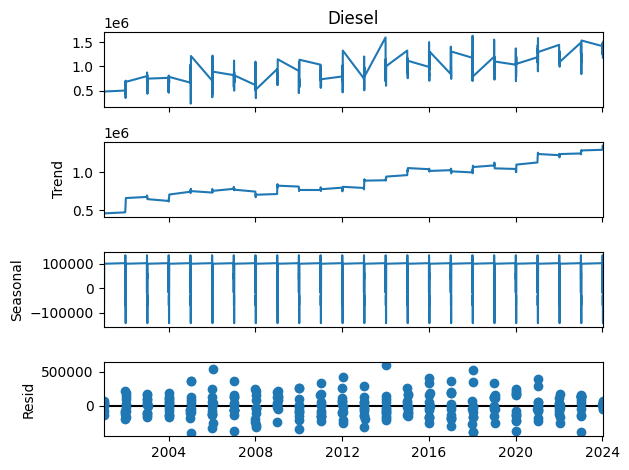

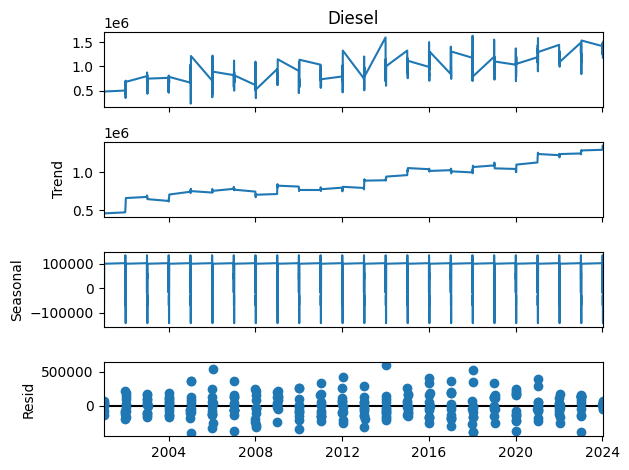

In [14]:
descomposicion = seasonal_decompose(diesel_imp_h, period= 12)
descomposicion.plot()

In [15]:
print('Resultados del Test de Dickey-Fuller para Diesel')
dfTest = adfuller(diesel_imp_h, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba', 'p-value', '# de retardos usados', '# de observaciones usadas'])
for key, value in dfTest[4].items():
    salidaDf['Critical Value (%s)' % key] = value
print(salidaDf)

Resultados del Test de Dickey-Fuller para Diesel
Estadístico de prueba         -0.639188
p-value                        0.861879
# de retardos usados          13.000000
# de observaciones usadas    274.000000
Critical Value (1%)           -3.454444
Critical Value (5%)           -2.872147
Critical Value (10%)          -2.572422
dtype: float64


In [16]:
print('Resultados del Test de Dickey-Fuller para una diferenciación de la serie Diesel')

diesel_imp_h_diff = diesel_imp_h.diff()
diesel_imp_h_diff.fillna(0, inplace=True)

dfTest = adfuller(diesel_imp_h_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba', 'p-value', '# de retardos usados', '# de observaciones usadas'])
for key, value in dfTest[4].items():
    salidaDf['Critical Value (%s)' % key] = value
print(salidaDf)

Resultados del Test de Dickey-Fuller para una diferenciación de la serie Diesel
Estadístico de prueba       -9.199487e+00
p-value                      2.020119e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.750000e+02
Critical Value (1%)         -3.454355e+00
Critical Value (5%)         -2.872108e+00
Critical Value (10%)        -2.572401e+00
dtype: float64


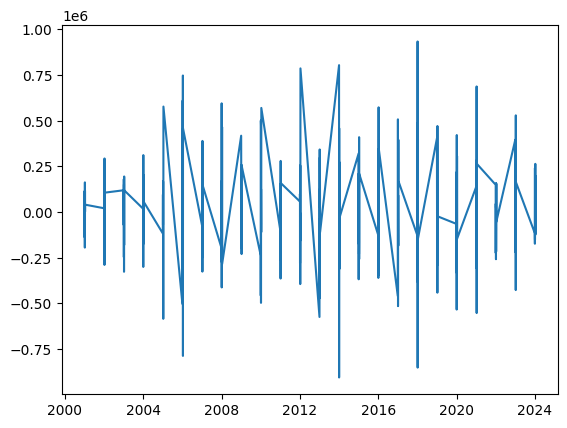

In [18]:
plt.plot(diesel_imp_h_diff)

In [19]:
scaler = StandardScaler()
diesel_imp_h_diff_scaled = scaler.fit_transform(diesel_imp_h_diff.values.reshape(-1, 1))
diesel_imp_h_diff_scaled[1:7]

array([[-0.29126598],
       [ 0.30198675],
       [-0.51468174],
       [ 0.40716705],
       [-0.21165128],
       [-0.72515659]])

# Entrenamiento

In [20]:
total_len = len(diesel_imp_h_diff_scaled)

train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

train = diesel_imp_h_diff_scaled[:train_end]
validation = diesel_imp_h_diff_scaled[train_end:val_end]
test = diesel_imp_h_diff_scaled[val_end:]

train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [21]:
train, type(train)

(array([[-0.01189193],
        [-0.29126598],
        [ 0.30198675],
        [-0.51468174],
        [ 0.40716705],
        [-0.21165128],
        [-0.72515659],
        [ 0.57843865],
        [-0.53070488],
        [ 0.41509447],
        [-0.00731037],
        [ 0.13308451],
        [ 0.06128615],
        [ 0.6699143 ],
        [-0.93996985],
        [-0.04060818],
        [ 0.25485206],
        [-0.01537621],
        [ 0.49851177],
        [-1.07173775],
        [ 1.05599981],
        [ 0.2245794 ],
        [-0.48785221],
        [ 0.37285986],
        [ 0.42077902],
        [-0.12656474],
        [-0.27446242],
        [ 0.64174302],
        [-0.91635666],
        [ 0.15845792],
        [ 0.53583585],
        [-1.2082744 ],
        [ 0.42892137],
        [-0.67526023],
        [ 0.69626346],
        [ 0.41983177],
        [ 0.04962074],
        [-1.11163247],
        [ 1.12339345],
        [ 0.12333903],
        [-0.65029343],
        [-0.64242234],
        [ 0.00916804],
        [ 0

In [22]:
from operator import concat

def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos), 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)

In [23]:
x_train

array([[-0.01189193],
       [-0.29126598],
       [ 0.30198675],
       [-0.51468174],
       [ 0.40716705],
       [-0.21165128],
       [-0.72515659],
       [ 0.57843865],
       [-0.53070488],
       [ 0.41509447],
       [-0.00731037],
       [ 0.13308451],
       [ 0.06128615],
       [ 0.6699143 ],
       [-0.93996985],
       [-0.04060818],
       [ 0.25485206],
       [-0.01537621],
       [ 0.49851177],
       [-1.07173775],
       [ 1.05599981],
       [ 0.2245794 ],
       [-0.48785221],
       [ 0.37285986],
       [ 0.42077902],
       [-0.12656474],
       [-0.27446242],
       [ 0.64174302],
       [-0.91635666],
       [ 0.15845792],
       [ 0.53583585],
       [-1.2082744 ],
       [ 0.42892137],
       [-0.67526023],
       [ 0.69626346],
       [ 0.41983177],
       [ 0.04962074],
       [-1.11163247],
       [ 1.12339345],
       [ 0.12333903],
       [-0.65029343],
       [-0.64242234],
       [ 0.00916804],
       [ 0.72619215],
       [ 0.15074017],
       [-0

In [24]:

y_train, type(y_train)

(array([-0.29126598,  0.30198675, -0.51468174,  0.40716705, -0.21165128,
        -0.72515659,  0.57843865, -0.53070488,  0.41509447, -0.00731037,
         0.13308451,  0.06128615,  0.6699143 , -0.93996985, -0.04060818,
         0.25485206, -0.01537621,  0.49851177, -1.07173775,  1.05599981,
         0.2245794 , -0.48785221,  0.37285986,  0.42077902, -0.12656474,
        -0.27446242,  0.64174302, -0.91635666,  0.15845792,  0.53583585,
        -1.2082744 ,  0.42892137, -0.67526023,  0.69626346,  0.41983177,
         0.04962074, -1.11163247,  1.12339345,  0.12333903, -0.65029343,
        -0.64242234,  0.00916804,  0.72619215,  0.15074017, -0.22467916,
         0.24707578,  0.18719198, -0.44315127,  0.06328379,  0.33462749,
        -0.26902636,  0.59709529,  0.59346967, -0.99797663,  0.15120037,
        -2.14860215,  1.60097041, -0.14430927,  2.09339394, -1.85020367,
         0.20328491, -0.09576191,  0.68342084, -0.4232399 , -1.69503782,
         2.21543758, -1.35436011, -0.4873258 ,  2.7

# Creando el modelo

In [25]:
(x_train.shape[0], 1, 1)

(171, 1, 1)

In [26]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, 1))
x_val = np.reshape(x_val, (x_val.shape[0], 1, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 1, 1))
len(x_val)

56

In [27]:
unidades = 10
paso = 1  # lags, 1 lag es un mes.
caracteristicas = 1  # es univariada
lote = 1

modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades,
    input_shape=(paso, caracteristicas),
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

/Users/hansellopez/Documents/Projects/DataScience/LSTM_DS/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
unidades = 10
paso = 1  # lags, 1 lag es un mes.
caracteristicas = 1  # es univariada
lote = 1

modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades,
    input_shape=(paso, caracteristicas),
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [32]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - loss: 0.6102 - val_loss: 1.1464
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.5658 - val_loss: 1.0961
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 0.5332 - val_loss: 1.0603
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.5100 - val_loss: 1.0369
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.4949 - val_loss: 1.0229
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.4857 - val_loss: 1.0147
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.4805 - val_loss: 1.0097
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.4776 - val_loss: 1.0063
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 0.4760 - val_loss: 1.0038
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.4751 - val_loss: 1.0016
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 0.4746 - val_loss: 0.9996
Epoch 12/50
171/171 ━━━━━━━━━━

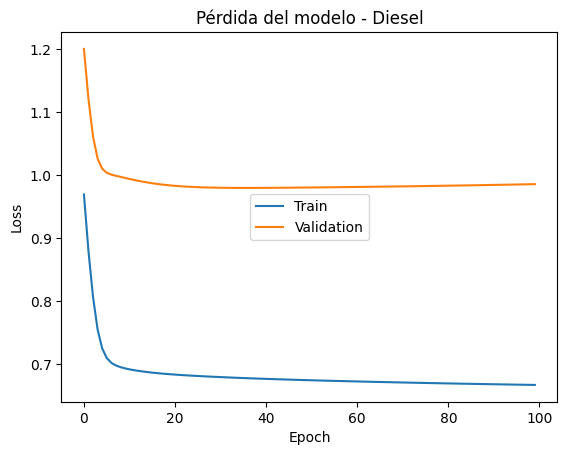

In [33]:
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Pérdida del modelo - Diesel')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center')
plt.show()

In [34]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x=x_train,
    y=y_train
)

print("Pérdida en Validación")
modelo1.evaluate(
    x=x_val,
    y=y_val
)

print("Pérdida en Prueba (Test)")
modelo1.evaluate(
    x=x_test,
    y=y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5588 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9380
Pérdida en Prueba (Test)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5728


0.5587592124938965

In [35]:
prediccion_val = []

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    i = 0
    for X in data:
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            yhat = yhat + Series[(n + dif_cant * i)]
        prediccion[i] = yhat[0][0]
        i += 1
    return prediccion

prediccion_val = prediccion_fun(
    x_val, modelo1, 1, scaler, dif=True, dif_cant=1, Series=diesel_imp_h.values, n=train_end)

prediccion_test = prediccion_fun(
    x_test, modelo1, 1, scaler, dif=True, dif_cant=1, Series=diesel_imp_h.values, n=len(diesel_imp_h.values) - len(x_test))

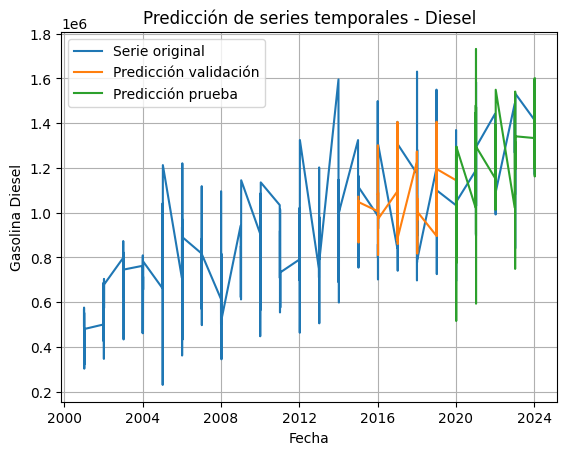

In [36]:
df_val = pd.DataFrame(prediccion_val, index=diesel_imp_h[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=diesel_imp_h[val_end:].index[:len(prediccion_test)])

plt.plot(diesel_imp_h, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales - Diesel')
plt.xlabel('Fecha')
plt.ylabel('Gasolina Diesel')
plt.grid(True)
plt.show()

In [37]:
unidades = 10
paso = 1  # lags, 1 lag es un mes.
caracteristicas = 1  # es univariada
lote = 1

modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades,
    input_shape=(paso, caracteristicas),
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

/Users/hansellopez/Documents/Projects/DataScience/LSTM_DS/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

# Segundo Model 

In [38]:
# Supón que ya tienes diesel_imp_h_diff_scaled definido y escalado
total_len = len(diesel_imp_h_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = diesel_imp_h_diff_scaled[:train_end]
validation = diesel_imp_h_diff_scaled[train_end:val_end]
test = diesel_imp_h_diff_scaled[val_end:]

# Redimensionar para LSTM univariante
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

In [39]:
unidades = 32   # Aumentamos el número de unidades
paso = 6        # Aumentamos los lags a 6 (en el primero era 1)
caracteristicas = 1  # es univariada
lote = 1
epocas = 150    # Aumentamos el número de épocas

In [40]:
def supervisada(serie, retrasos=6):  # Ahora 6 lags
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos), 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train2, y_train2 = supervisada(train, retrasos=6)
x_val2, y_val2 = supervisada(validation, retrasos=6)
x_test2, y_test2 = supervisada(test, retrasos=6)

# Reshape para LSTM: (samples, time_steps, features)
x_train2 = np.reshape(x_train2, (x_train2.shape[0], 6, 1))
x_val2 = np.reshape(x_val2, (x_val2.shape[0], 6, 1))
x_test2 = np.reshape(x_test2, (x_test2.shape[0], 6, 1))

In [41]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False
))
modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
modelo2.compile(loss='mean_squared_error', optimizer="adam")

In [43]:
epocas = 100
history2 = modelo2.fit(
    x=x_train2,
    y=y_train2,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val2, y_val2),
    verbose=1
)

Epoch 1/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6683 - val_loss: 1.0510
Epoch 2/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.5398 - val_loss: 0.8887
Epoch 3/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.4560 - val_loss: 0.8369
Epoch 4/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.4355 - val_loss: 0.8339
Epoch 5/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.4343 - val_loss: 0.8337
Epoch 6/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.4334 - val_loss: 0.8340
Epoch 7/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.4325 - val_loss: 0.8348
Epoch 8/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.4317 - val_loss: 0.8364
Epoch 9/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.4312 - val_loss: 0.8385
Epoch 10/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 0.4309 - val_loss: 0.8413
Epoch 11/100
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.4307 - val_loss: 0.8446
Epoch 12/100
166/166 

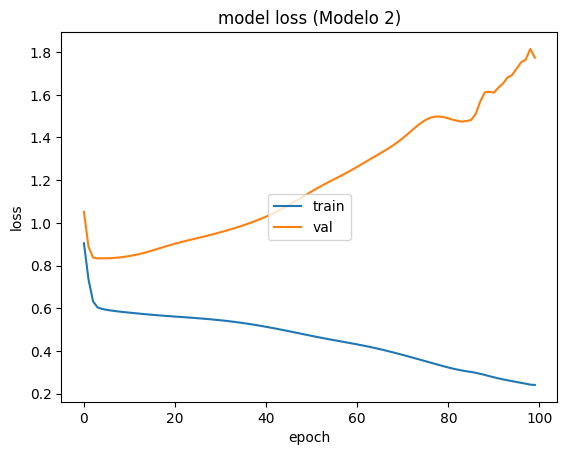

In [44]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss (Modelo 2)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')
plt.show()

In [45]:
print("Pérdida en Train (Modelo 2)")
modelo2.evaluate(x_train2, y_train2)

print("Pérdida en Validación (Modelo 2)")
modelo2.evaluate(x_val2, y_val2)

print("Pérdida en Test (Modelo 2)")
modelo2.evaluate(x_test2, y_test2)

Pérdida en Train (Modelo 2)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2287 
Pérdida en Validación (Modelo 2)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9109
Pérdida en Test (Modelo 2)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7354


0.7639800906181335

In [48]:
# Función de predicción (sin cambios)
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * (len(data))
    i = 0
    for X in data:
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            yhat = yhat + Series[(n + dif_cant * i)]
        prediccion[i] = yhat[0][0]
        i = i + 1
    return prediccion

# Aplicación de la función al modelo 2 y datos de diesel
prediccion_val2 = prediccion_fun(
    x_val2, modelo2, 1, scaler,
    dif=True, dif_cant=1,
    Series=diesel_imp_h.values,  # Reemplazo aquí
    n=train_end
)

prediccion_test2 = prediccion_fun(
    x_test2, modelo2, 1, scaler,
    dif=True, dif_cant=1,
    Series=diesel_imp_h.values,  # Reemplazo aquí
    n=len(diesel_imp_h.values) - len(x_test2)
)

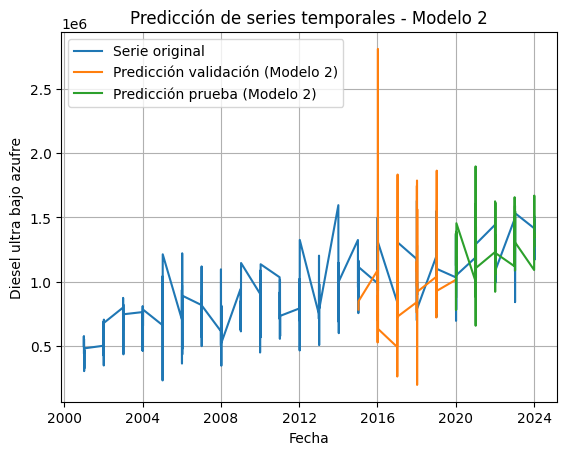

In [49]:
# Crear dataframes de predicciones con el índice de fechas correcto
df_val2 = pd.DataFrame(prediccion_val2, index=diesel_imp_h[train_end+paso:val_end].index)
df_test2 = pd.DataFrame(prediccion_test2, index=diesel_imp_h[val_end:].index[:len(prediccion_test2)])

# Graficar las predicciones vs. serie original
plt.plot(diesel_imp_h, label='Serie original')
plt.plot(df_val2, label='Predicción validación (Modelo 2)')
plt.plot(df_test2, label='Predicción prueba (Modelo 2)')

plt.legend()
plt.title('Predicción de series temporales - Modelo 2')
plt.xlabel('Fecha')
plt.ylabel('Diesel ultra bajo azufre')
plt.grid(True)
plt.show()

In [50]:
diesel_con = pd.read_csv('./data/consumo.csv', parse_dates=['Fecha'], dayfirst=True)
diesel_con.set_index('Fecha', inplace=True)
diesel_con_h = diesel_con['Diesel ultra bajo azufre']

diesel_con_h.head()

Fecha
2000-01-01    0.0
2000-01-02    0.0
2000-01-03    0.0
2000-01-04    0.0
2000-01-05    0.0
Name: Diesel ultra bajo azufre, dtype: float64

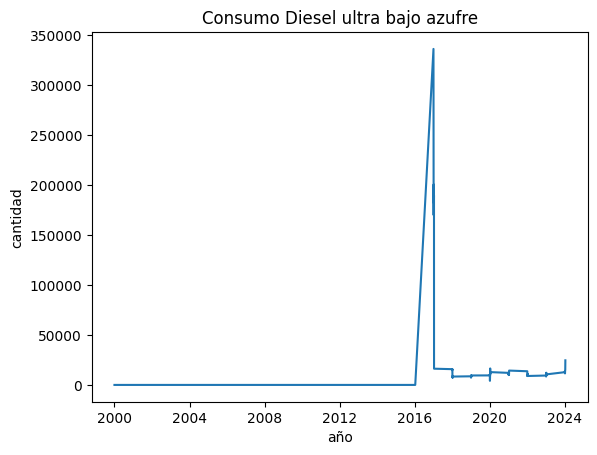

In [51]:
plt.plot(diesel_con_h)
plt.gca().set(title="Consumo Diesel ultra bajo azufre", ylabel="cantidad", xlabel="año")
plt.show()

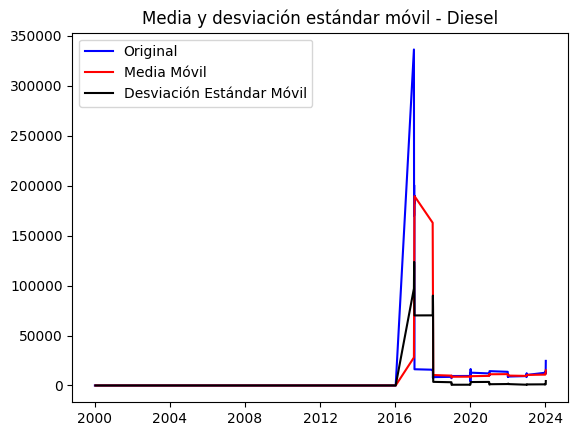

In [52]:
# Se calcula la media móvil y la desviación estándar móvil de los últimos 12 meses.
mediaMovil = diesel_con_h.rolling(window=12).mean()
deMovil = diesel_con_h.rolling(window=12).std()

# Se grafican los resultados.
original = plt.plot(diesel_con_h, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label='Media Móvil')
ds = plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
plt.legend(loc='best')
plt.title('Media y desviación estándar móvil - Diesel')
plt.show(block=False)

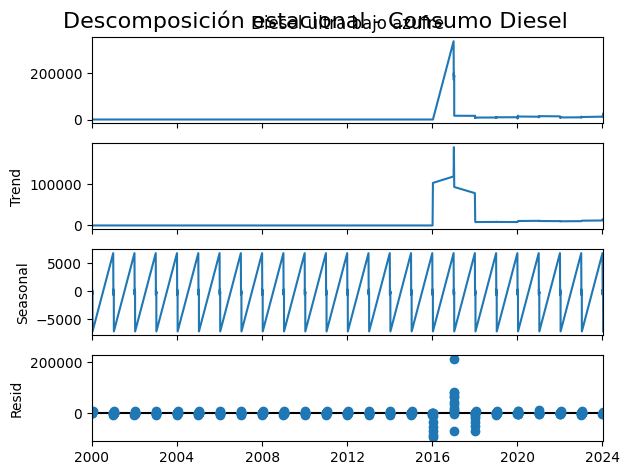

In [54]:
# Descomposición estacional de la serie Diesel
descomposicion = seasonal_decompose(diesel_con_h, period=12)
descomposicion.plot()
plt.suptitle('Descomposición estacional - Consumo Diesel', fontsize=16)
plt.show()

In [55]:
print('Resultados del Test de Dickey Fuller - Consumo Diesel')
dfTest = adfuller(diesel_con_h, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key, value in dfTest[4].items():
    salidaDf['Critical Value (%s)' % key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller - Consumo Diesel
Estadístico de prueba         -3.308084
p-value                        0.014521
# de retardos usados          12.000000
# de observaciones usadas    287.000000
Critical Value (1%)           -3.453342
Critical Value (5%)           -2.871664
Critical Value (10%)          -2.572164
dtype: float64


In [56]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie - Consumo Diesel')
diesel_con_h_diff = diesel_con_h.diff()
diesel_con_h_diff.fillna(0, inplace=True)
dfTest = adfuller(diesel_con_h_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba', 'p-value', '# de retardos usados', '# de observaciones usadas'])
for key, value in dfTest[4].items():
    salidaDf['Critical Value (%s)' % key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie - Consumo Diesel
Estadístico de prueba       -7.245526e+00
p-value                      1.836575e-10
# de retardos usados         1.100000e+01
# de observaciones usadas    2.880000e+02
Critical Value (1%)         -3.453262e+00
Critical Value (5%)         -2.871628e+00
Critical Value (10%)        -2.572146e+00
dtype: float64


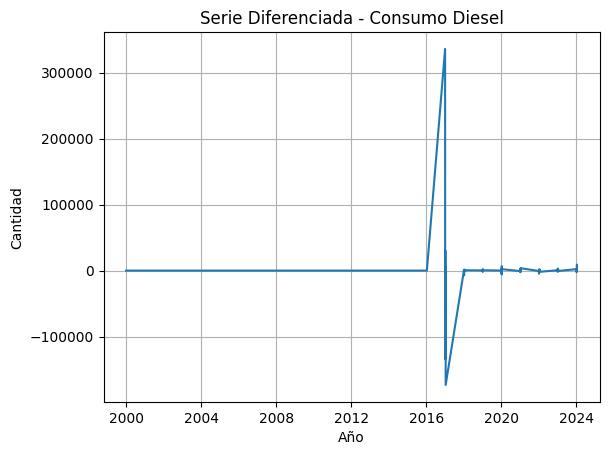

In [57]:
plt.plot(diesel_con_h_diff)
plt.gca().set(title="Serie Diferenciada - Consumo Diesel", ylabel="Cantidad", xlabel="Año")
plt.grid(True)
plt.show()

In [58]:
scaler = StandardScaler()
diesel_con_h_diff_scaled = scaler.fit_transform(diesel_con_h_diff.values.reshape(-1, 1))
diesel_con_h_diff_scaled[1:7]

array([[-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456]])

In [59]:
total_len = len(diesel_con_h_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = diesel_con_h_diff_scaled[:train_end]
validation = diesel_con_h_diff_scaled[train_end:val_end]
test = diesel_con_h_diff_scaled[val_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 300
Train: 180 | Validation: 60 | Test: 60


In [60]:
train, type(train)

(array([[-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0.00347456],
        [-0

In [61]:
from operator import concat

def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos), 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train, y_train = supervisada(train)
x_val, y_val = supervisada(validation)
x_test, y_test = supervisada(test)

In [62]:
x_train

array([[-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0.00347456],
       [-0

In [63]:

y_train, type(y_train)

(array([-0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.00347456, -0.00347456,
        -0.00347456, -0.00347456, -0.00347456, -0.0

# Creando el modelo

In [64]:
(x_train.shape[0],1,1)

(179, 1, 1)

In [65]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

59

In [66]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

/Users/hansellopez/Documents/Projects/DataScience/LSTM_DS/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [70]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 1.0351e-06 - val_loss: 5.0576
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 6.6436e-07 - val_loss: 5.0575
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 6.6420e-07 - val_loss: 5.0576
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 6.6402e-07 - val_loss: 5.0575
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 6.6385e-07 - val_loss: 5.0576
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 6.6368e-07 - val_loss: 5.0575
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 6.6350e-07 - val_loss: 5.0576
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 6.6333e-07 - val_loss: 5.0576
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 6.6316e-07 - val_loss: 5.0576
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 6.6298e-07 - val_loss: 5.0576
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 6.6281e-07 - val

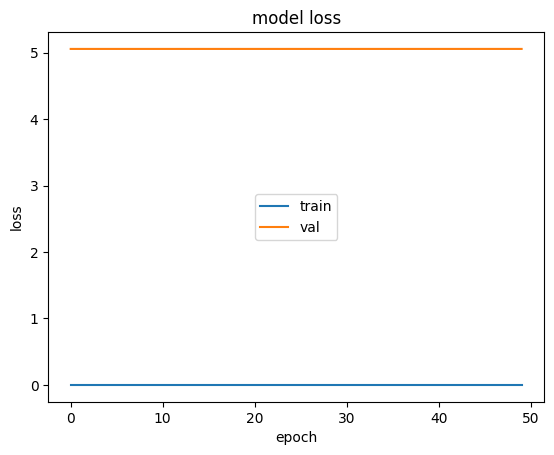

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [72]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5601e-07 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9168
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104


0.009979245252907276

In [77]:
prediccion_val = []

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * len(data)
    i = 0
    for X in data:
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            yhat = yhat + Series[n + dif_cant * i]
        prediccion[i] = yhat[0][0]
        i += 1
    return prediccion

# ✅ Adaptado a DIESEL: usar la serie original de Diesel ultra bajo azufre
serie_diesel = diesel_con_h

# Hacer predicciones
prediccion_val = prediccion_fun(x_val, modelo1, 1, scaler, dif=True, dif_cant=1, Series=serie_diesel.values, n=train_end)
prediccion_test = prediccion_fun(x_test, modelo1, 1, scaler, dif=True, dif_cant=1, Series=serie_diesel.values, n=len(serie_diesel.values) - len(x_test))

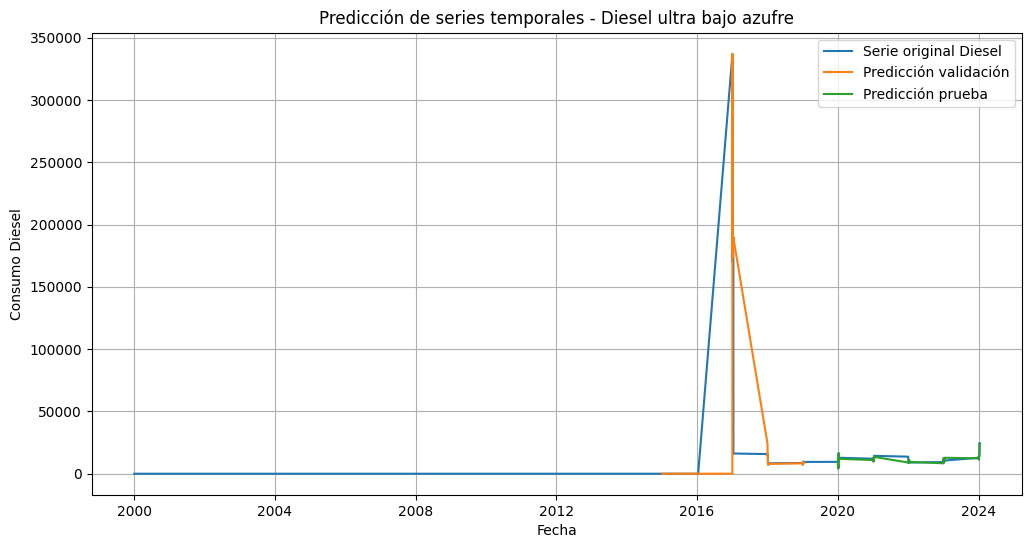

In [78]:
# Crear DataFrames de predicción con índices correctos de diesel_con_h
df_val = pd.DataFrame(prediccion_val, index=diesel_con_h[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=diesel_con_h[val_end:].index[:len(prediccion_test)])

# Graficar las predicciones vs la serie original
plt.figure(figsize=(12, 6))
plt.plot(diesel_con_h, label='Serie original Diesel')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales - Diesel ultra bajo azufre')
plt.xlabel('Fecha')
plt.ylabel('Consumo Diesel')
plt.grid(True)
plt.show()

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Definición del modelo
unidades = 10          # número de neuronas en la capa LSTM
paso = 1               # número de pasos de tiempo (lags)
caracteristicas = 1    # univariada (solo una característica)
lote = 1               # batch size

modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # no guarda estado entre batches
))
modelo1.add(Dense(1))  # salida unitaria

# Resumen del modelo
modelo1.summary()

/Users/hansellopez/Documents/Projects/DataScience/LSTM_DS/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# Supón que ya tienes diesel_con_h_diff_scaled definido y escalado
total_len = len(diesel_con_h_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = diesel_con_h_diff_scaled[:train_end]
validation = diesel_con_h_diff_scaled[train_end:val_end]
test = diesel_con_h_diff_scaled[val_end:]

# Redimensionar para LSTM univariante
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

In [81]:
# Parámetros para el segundo modelo LSTM aplicando a la serie Diesel
unidades = 32           # Más unidades en la capa LSTM
paso = 6                # 6 lags (pasos de tiempo)
caracteristicas = 1     # Univariada: solo Diesel
lote = 1                # Batch size de 1
epocas = 150            # Aumentamos el número de épocas

In [82]:
def supervisada(serie, retrasos=6):  # 6 lags para Diesel
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos), 0]
        valor_sig = serie[i + retrasos, 0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

# Generar conjuntos supervisados con 6 lags
x_train2, y_train2 = supervisada(train, retrasos=6)
x_val2, y_val2 = supervisada(validation, retrasos=6)
x_test2, y_test2 = supervisada(test, retrasos=6)

# Reshape para LSTM: (samples, time_steps, features)
x_train2 = np.reshape(x_train2, (x_train2.shape[0], 6, 1))
x_val2 = np.reshape(x_val2, (x_val2.shape[0], 6, 1))
x_test2 = np.reshape(x_test2, (x_test2.shape[0], 6, 1))

In [83]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

modelo2 = Sequential()
modelo2.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # sin mantener estados entre batches
))
modelo2.add(Dense(1))
modelo2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Compilar modelo
modelo2.compile(optimizer='adam', loss='mean_squared_error')

# Asegurar que y tenga la forma adecuada
y_train2 = y_train2.reshape(-1, 1)
y_val2 = y_val2.reshape(-1, 1)

# Entrenamiento
epocas = 100
history2 = modelo2.fit(
    x=x_train2,
    y=y_train2,
    batch_size=lote,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val2, y_val2),
    verbose=1
)

Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7680e-06 - val_loss: 5.6191
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 2.7683e-14 - val_loss: 5.6191
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 7.3960e-20 - val_loss: 5.6191
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0000e+00 - val_loss: 5.6191
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.0000e+00 - val_loss: 5.6191
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.0000e+00 - val_loss: 5.6191
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0000e+00 - val_loss: 5.6191
Epoch 8/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0000e+00 - val_loss: 5.6191
Epoch 9/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.0000e+00 - val_loss: 5.6191
Epoch 10/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.0000e+00 - val_loss: 5.6191
Epoch 11/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0000e+0

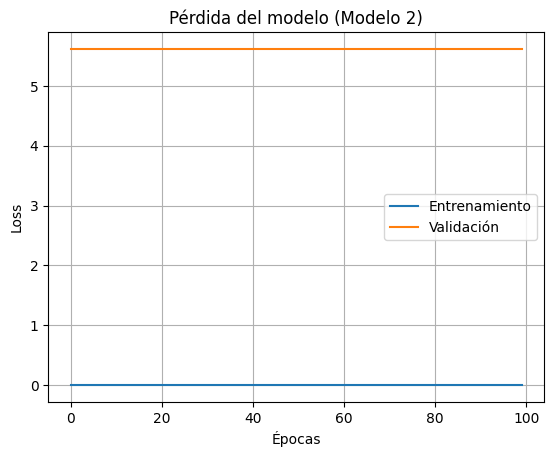

In [87]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Pérdida del modelo (Modelo 2)')
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='best')
plt.grid(True)
plt.show()

In [89]:
# Asegurar que las variables de salida tengan la forma correcta
y_train2 = np.reshape(y_train2, (-1, 1))
y_val2 = np.reshape(y_val2, (-1, 1))
y_test2 = np.reshape(y_test2, (-1, 1))

# Evaluar el modelo
print("Pérdida en Train (Modelo 2)")
loss_train = modelo2.evaluate(x_train2, y_train2, verbose=0)
print(f"Loss Train: {loss_train}")

print("Pérdida en Validación (Modelo 2)")
loss_val = modelo2.evaluate(x_val2, y_val2, verbose=0)
print(f"Loss Validación: {loss_val}")

print("Pérdida en Test (Modelo 2)")
loss_test = modelo2.evaluate(x_test2, y_test2, verbose=0)
print(f"Loss Test: {loss_test}")

Pérdida en Train (Modelo 2)
Loss Train: 5.421010862427522e-20
Pérdida en Validación (Modelo 2)
Loss Validación: 5.619097709655762
Pérdida en Test (Modelo 2)
Loss Test: 0.010539548471570015


In [92]:
# Alias para mantener compatibilidad con la función
imp_h = diesel_imp_h  # Asegúrate de que esta variable ya esté definida con los datos correctos de diésel

def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = [0] * (len(data))
    i = 0
    for X in data:
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            yhat = yhat + Series[(n + dif_cant * i)]
        prediccion[i] = yhat[0][0]
        i = i + 1
    return prediccion

prediccion_val2 = prediccion_fun(
    x_val2, modelo2, 1, scaler,
    dif=True, dif_cant=1,
    Series=imp_h.values, n=train_end
)

prediccion_test2 = prediccion_fun(
    x_test2, modelo2, 1, scaler,
    dif=True, dif_cant=1,
    Series=imp_h.values, n=len(imp_h.values) - len(x_test2)
)


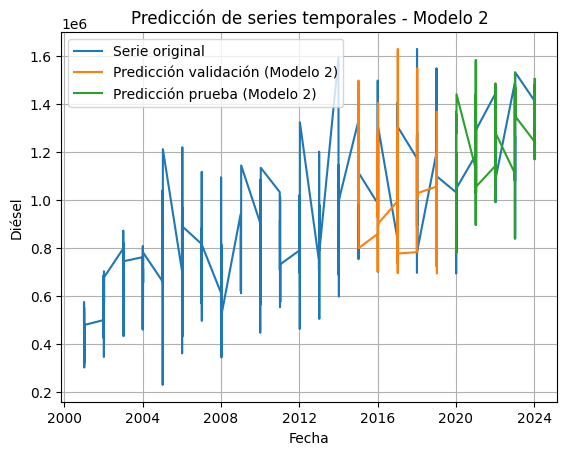

In [93]:
# Alias para evitar cambiar la estructura del código original
con_h = diesel_con_h  # índice temporal
imp_h = diesel_imp_h  # serie original invertida/escalada

# Construir DataFrames con los índices adecuados para validación y prueba
df_val2 = pd.DataFrame(prediccion_val2, index=con_h[train_end + paso:val_end].index)
df_test2 = pd.DataFrame(prediccion_test2, index=con_h[val_end:].index[:len(prediccion_test2)])

# Graficar predicción vs serie real
plt.plot(imp_h, label='Serie original')
plt.plot(df_val2, label='Predicción validación (Modelo 2)')
plt.plot(df_test2, label='Predicción prueba (Modelo 2)')

plt.legend()
plt.title('Predicción de series temporales - Modelo 2')
plt.xlabel('Fecha')
plt.ylabel('Diésel')  # Cambiado para reflejar el tipo de combustible
plt.grid(True)
plt.show()